In [1]:
from sklearn.datasets import olivetti_faces
d = olivetti_faces.fetch_olivetti_faces()
print(type(d))
import numpy as np
Y, X = np.array(d['data']), np.array(d['target'])
print(f'Data shape: {Y.shape}')
print(f'Label shape: {X.shape}')
from copy import deepcopy
from math import sqrt
import matplotlib.pyplot as plt

def clip(x, bound):
    den = max(1, np.linalg.norm(x, 1)/bound)
    output = x/den
    #print('Output Norm:', np.linalg.norm(output))
    return output

def clip_gaussian(x, bound):
    den = max(1, np.linalg.norm(x)/bound)
    output = x/den
    #print('Output Norm:', np.linalg.norm(output))
    return output

from math import pow, sqrt, log
def add_noise_gaussian(eps, delta, sensitivity, size=1):
    # Add 1D noise to data
    # Need to precalculate per data epsilon value
    constant = np.sqrt(2*np.log(1.25/delta))
    sigma = (constant*sensitivity)/eps
    #print('std:', sigma, 'Noise:', np.random.normal(loc=0, scale=sigma))
    if size == 1:
        return np.random.normal(loc=0, scale=sigma, size=size)[0]
    #elif type(size) == int:
    return np.random.normal(loc=0, scale=sigma, size=size)
    #else:

    #elif len(size) > 1:
    #    return np.random.normal(loc=0, sigma=sigma, )

def add_noise(eps, delta, sensitivity, size=1):
    #constant = np.sqrt(2*np.log(1.25/delta))
    sigma = sensitivity/eps
    if size == 1:
        return np.random.laplace(loc=0, scale=sigma, size=size)[0]
    #elif type(size) == int:
    return np.random.laplace(loc=0, scale=sigma, size=size)
    #else:

# Test Noise
x = 1
print(x, x+add_noise(eps=1, delta=0.01, sensitivity=1))
y = np.array([1, 2])
print(y, y+add_noise(eps=1, delta=0.01, sensitivity=1, size=2))
z = np.array([[1, 2], [3, 4]])
print(z, add_noise(eps=1, delta=0.01, sensitivity=1, size=(2, 2)))

print(np.linalg.norm(clip(y, 1), 1))


from math import exp, log
def advanced_composition(eps, delta, iterations):
    delta_prime = delta
    term1=iterations*eps*(exp(eps)-1)
    term2=eps*sqrt(2*iterations*log(1/delta_prime))

    return term1+term2, iterations*delta+delta_prime # eps, delta 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.olivetti_faces module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
<class 'sklearn.utils.Bunch'>
Data shape: (400, 4096)
Label shape: (400,)
1 0.245656408003887
[1 2] [0.96324667 0.9599373 ]
[[1 2]
 [3 4]] [[-2.83551586 -0.56079722]
 [ 0.23859792 -0.5711635 ]]
1.0


In [2]:
class FA:
    def __init__(self, Y_main, Delta_main, W_main, Psi_main, latent_dims, max_iters=10):
        self.Y = deepcopy(Y_main)
        self.N = self.Y.shape[0]
        self.latent_dims = latent_dims
        self.max_iters = max_iters 

        # Initialize
        self.Delta = deepcopy(Delta_main)
        self.W = deepcopy(W_main)
        self.Psi = deepcopy(Psi_main)


    def log_likelihood_loss(self): # compute loss

        # Get constant
        #print('N', self.N)
        
        _, psi_det = np.linalg.slogdet(self.Psi)
        term1 = -0.5*self.N*psi_det

        # Get Latent Value
        X1 = np.dot(np.dot(np.linalg.inv(self.Psi), self.W), self.G)
        X = np.dot(self.Y, X1)

        matrix_term = self.Y.T-np.dot(self.W, X.T)
        S = (1/self.N)*np.dot(matrix_term, matrix_term.T)

        term2 = -0.5*self.N*np.trace(np.dot(S, np.linalg.inv(self.Psi)))

        return term1+term2

    def update(self):
        # Compute G
        I = np.eye(self.latent_dims)
        G_term = np.dot(np.dot(self.W.T, np.linalg.inv(self.Psi)), self.W)
        self.G = np.linalg.inv(I + G_term) 

        m_term = np.dot(np.dot(self.G, self.W.T), np.linalg.inv(self.Psi))
        W1 = np.dot(self.Delta, m_term.T)
        W2 = np.linalg.inv(self.G + np.dot(np.dot(m_term, self.Delta), m_term.T))
        self.W = np.dot(W1, W2)

        Psi_term = np.dot(np.dot(self.W, m_term), self.Delta)#/Y.shape[0]
        phi = (self.Delta - Psi_term)
        self.Psi = np.diag(np.diag(phi))
 
    def run(self):
        lls = []
        for iterations in range(self.max_iters):
            self.update()
            fig = plt.figure(figsize=(16, 8), dpi=80)
            print('Log Likelihood Loss', self.log_likelihood_loss())
            lls.append(self.log_likelihood_loss())
            for indx in range(self.W.shape[1]):
                img = deepcopy(self.W[:, indx])
                #print(img, type(img))
                img_shape = int(sqrt(img.shape[0]))
                #print(img)
                img = img.reshape(img_shape, img_shape)
                plt.subplot(1, 10, indx+1)
                plt.tight_layout()
                plt.imshow(img, cmap='gray', interpolation='none')
                plt.xticks([])
                plt.yticks([])
            plt.show()

        plt.figure()
        plt.plot(range(len(lls)), lls)
        plt.title('Log Likelihood Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Log Likelihood Loss')
        plt.show()


In [3]:
''' Privatize PCA and FA
Use Analyze Gauss and normalize the rows of the data vector Y.
Then add appropriate gaussian noise to YTY so as to privatize a pxp 
matrix. Do PCA before if non-private else do it post.
'''

from sklearn import preprocessing
def FA_init(Y_main, private=False, latent_dims=10, clip_bound = 1, eps=1, delta = 1):
    Y = deepcopy(Y_main)
    N = Y.shape[0]
    #if self.private: # CLIP DATA TO REDUCE SENSITIVITY
    Delta = (Y.T.dot(Y))

    _, eigvecs=np.linalg.eig(Delta/N)
    W = eigvecs[:,:latent_dims] # initialize W with PCA
    Psi = np.diag(np.diag(Delta/N)) # initialize Psi

    # only normalize
    if private:
        for n in range(N):
            Y[n, :] = deepcopy(clip_gaussian(Y[n, :], clip_bound))
        Delta = (Y.T.dot(Y))

    # add noise later
    if private:
        Delta+=add_noise_gaussian(eps, delta, sensitivity=clip_bound**2, size=Delta.shape)
    return Delta, W, Psi



Log Likelihood Loss 79691483967.25693


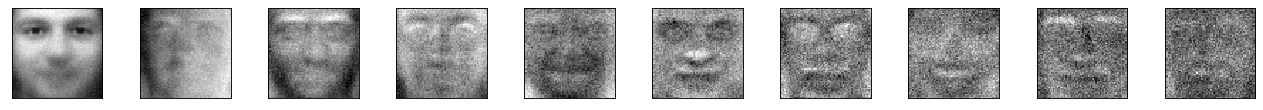

Log Likelihood Loss -91384485.98244186


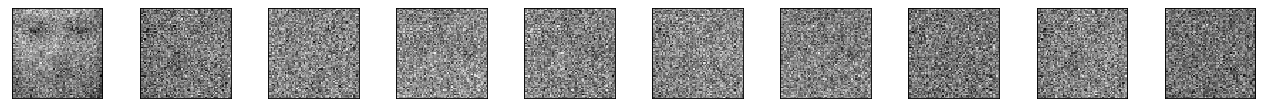

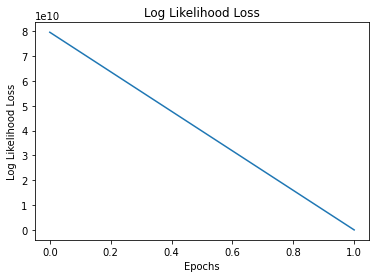

In [4]:
# eps 500
Delta_private1, W_private1, Psi_private1 = FA_init(Y, True, 10, clip_bound = 1, eps=500, delta = 0.0001)
fa_private = FA(Y, Delta_private1, np.real(W_private1), np.real(Psi_private1), latent_dims = 10, max_iters=2) # eps = 0.3
fa_private.run()

Log Likelihood Loss -8948643630243.145


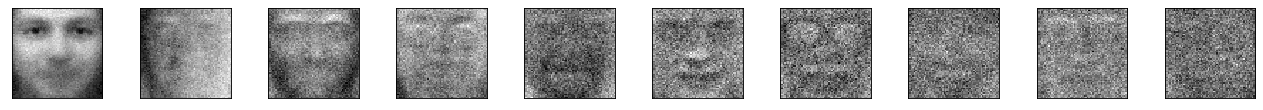

Log Likelihood Loss -6908913877.415997


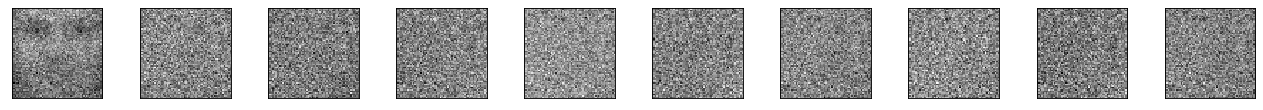

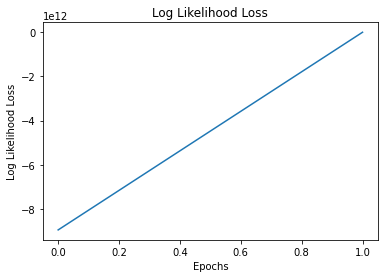

In [5]:
Delta_private1, W_private1, Psi_private1 = FA_init(Y, True, 10, clip_bound = 1, eps=250, delta = 0.0001)
fa_private = FA(Y, Delta_private1, np.real(W_private1), np.real(Psi_private1), latent_dims = 10, max_iters=2) # eps = 0.3
fa_private.run()

Log Likelihood Loss 111960742543.24179


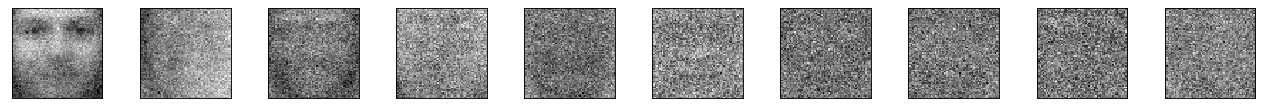

Log Likelihood Loss 12391528665.653944


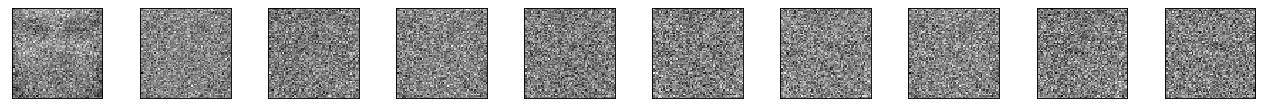

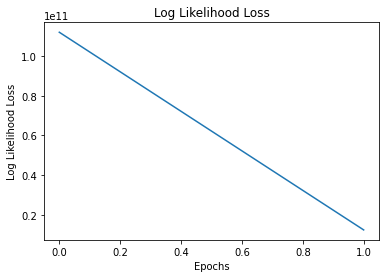

In [6]:
Delta_private1, W_private1, Psi_private1 = FA_init(Y, True, 10, clip_bound = 1, eps=100, delta = 0.0001)
fa_private = FA(Y, Delta_private1, np.real(W_private1), np.real(Psi_private1), latent_dims = 10, max_iters=2) # eps = 0.3
fa_private.run()

Log Likelihood Loss 212965678682.16074


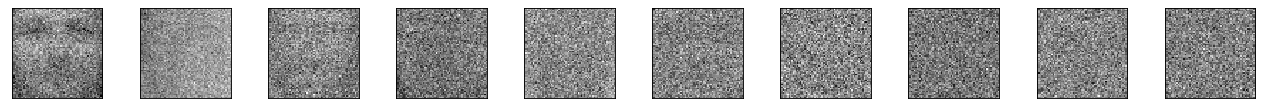

Log Likelihood Loss 5602445.2031585835


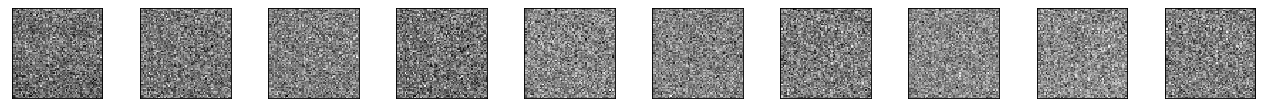

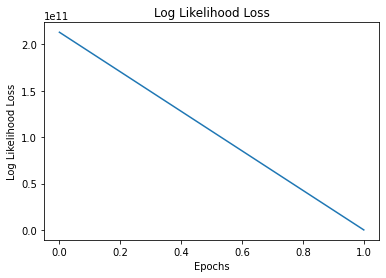

In [7]:
Delta_private1, W_private1, Psi_private1 = FA_init(Y, True, 10, clip_bound = 1, eps=50, delta = 0.0001)
fa_private = FA(Y, Delta_private1, np.real(W_private1), np.real(Psi_private1), latent_dims = 10, max_iters=2) # eps = 0.3
fa_private.run()

Log Likelihood Loss -4.7460983519369864e+16


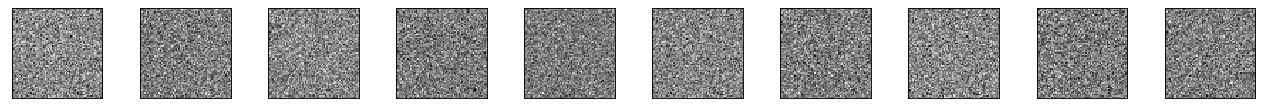

Log Likelihood Loss -5568207170.000381


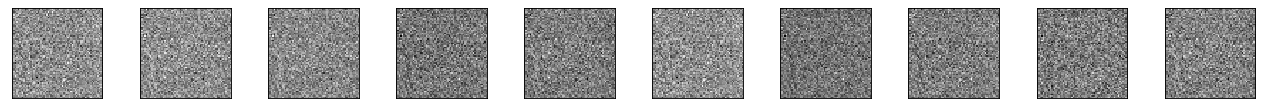

Log Likelihood Loss -354867792.5969647


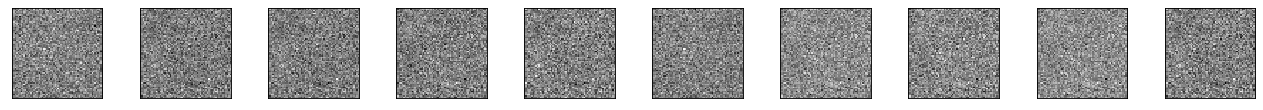

Log Likelihood Loss -9426898646792.438


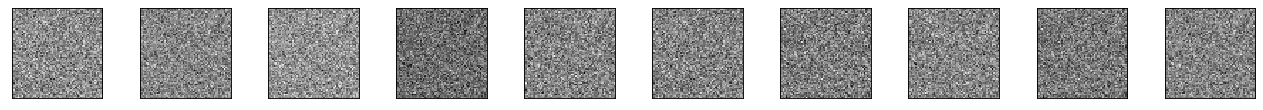

Log Likelihood Loss 6562577138.966995


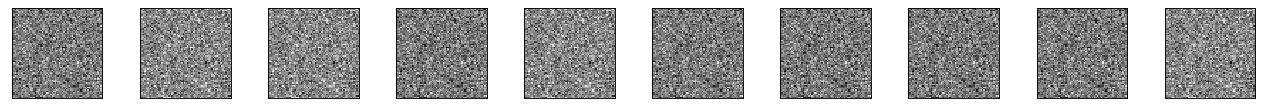

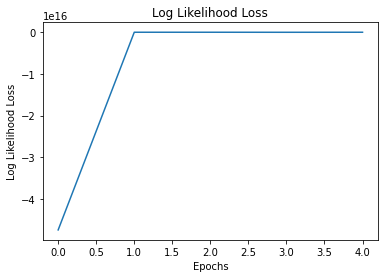

In [8]:
Delta_private1, W_private1, Psi_private1 = FA_init(Y, True, 10, clip_bound = 1, eps=10, delta = 1./400)
fa_private = FA(Y, Delta_private1, np.real(W_private1), np.real(Psi_private1), latent_dims = 10, max_iters=5) # eps = 0.3
fa_private.run()

Log Likelihood Loss -802583.1291693245


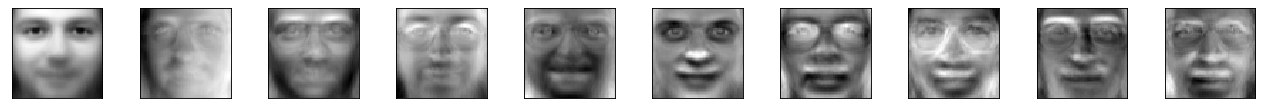

Log Likelihood Loss -972444.1515951161


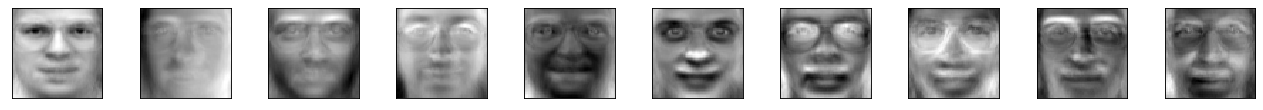

Log Likelihood Loss -700756.4430976195


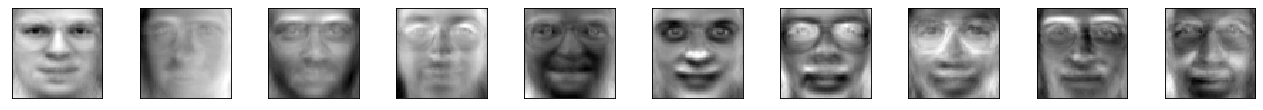

Log Likelihood Loss -687795.624545038


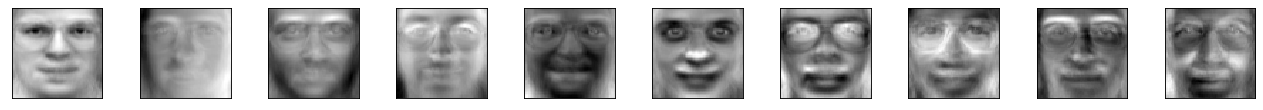

Log Likelihood Loss -683526.7859904835


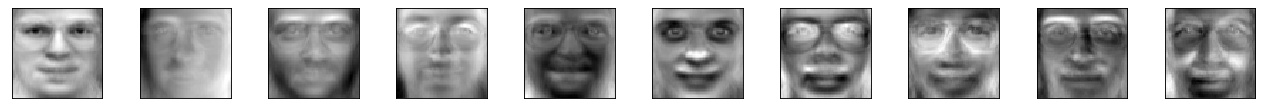

Log Likelihood Loss -681667.57241882


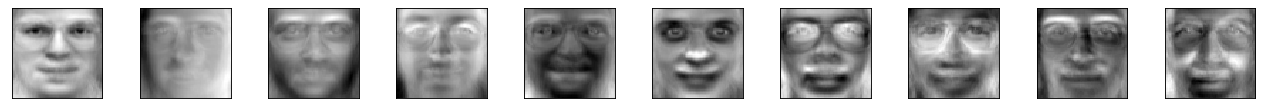

Log Likelihood Loss -680724.9559692624


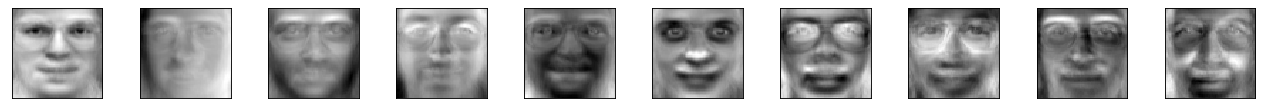

Log Likelihood Loss -680184.1516448653


In [ ]:
# TRUE RUN
Delta, W, Psi = FA_init(Y)
fa = FA(Y, Delta, W, Psi, latent_dims = 10, max_iters=10)   
fa.run()

In [ ]:
from math import log
def zCDP(eps, delta=0.0001, sensitivity=1, iterations=100):
    rho = (0.5/log(1.25/delta))*(eps**2)
    eps_output = iterations*(rho + sqrt(rho*log(1/delta))) 
    delta_output = iterations*delta
    return eps_output, delta_output